# <font color='red'>Clustering Assignment</font>

**There will be some functions that start with the word "grader" ex: grader_actors(), grader_movies(), grader_cost1() etc, you should not change those function definition.<br><br>Every Grader function has to return True.**

**Please check [clustering assignment helper functions](https://drive.google.com/file/d/1V29KhKo3YnckMX32treEgdtH5r90DIjU/view?usp=sharing) notebook before attempting this assignment.**

*  Read graph from the given <font color='blue'>movie_actor_network.csv</font> (note that the graph is bipartite graph.)

*  Using stellergaph and gensim packages, get the dense representation(128dimensional vector) of every node in the graph. [Refer <font color='blue'>Clustering_Assignment_Reference.ipynb</font>]

* Split the dense representation into actor nodes, movies nodes.(Write you code in <font color='blue'>def data_split()</font>)


# <font color='red'>Task 1 : Apply clustering algorithm to group similar actors</font>

 1. For this task consider only the actor nodes 
 2. Apply any clustering algorithm of your choice <br>
    Refer : https://scikit-learn.org/stable/modules/clustering.html
 3. Choose the number of clusters for which you have maximum score of <b>$Cost1*Cost2$</b><br>
 4. Cost1 = $\frac{1}{N}\sum_{\text{each cluster i}}  \frac{\text{(number of nodes in the largest connected component in the graph with the actor nodes and its movie neighbours in cluster i)}}{\text{(total number of nodes in that cluster i)}}$ where N= number of clusters 
<br> (Write your code in <font color='blue'>def cost1()</font>)<br>
 5. Cost2 = $\frac{1}{N}\sum_{\text{each cluster i}}  \frac{\text{(sum of degress of actor nodes in the graph with the actor nodes and its movie neighbours in cluster i)}}{\text{(number of unique movie nodes in the graph with the actor nodes and its movie neighbours in cluster i)}}$ where N= number of clusters 
 <br> (Write your code in <font color='blue'>def cost2()</font>)<br>
 6. Fit the clustering algorithm with the opimal number_of_clusters and get the cluster number for each node <br>
 7. Convert the d-dimensional dense vectors of nodes into 2-dimensional using dimensionality reduction techniques (preferably TSNE)<br>
 8. Plot the 2d scatter plot, with the node vectors after step e and give colors to nodes such that same cluster nodes will have same color

<img src='https://i.imgur.com/4SPYPFa.jpg'>

# <font color='red'>Task 2 : Apply clustering algorithm to group similar movies</font>


1. For this task consider only the movie nodes
2. Apply any clustering algorithm of your choice
3.Choose the number of clusters for which you have maximum score of $Cost1*Cost2$ <br>

    Cost1 = $\frac{1}{N}\sum_{\text{each cluster i}}  \frac{\text{(number of nodes in the largest connected component in the graph with the movie nodes and its actor neighbours in cluster i)}}{\text{(total number of nodes in that cluster i)}}$ where N= number of clusters <br>
(Write your code in <font color='blue'>def cost1()</font>)<br>
	
4. Cost2 = $\frac{1}{N}\sum_{\text{each cluster i}}  \frac{\text{(sum of degress of movie nodes in the graph with the movie nodes and its actor neighbours in cluster i)}}{\text{(number of unique actor nodes in the graph with the movie nodes and its actor neighbours in cluster i)}}$ 
where N= number of clusters 
<br>(Write your code in <font color='blue'>def cost2()</font>)<br>


**Algorithm for actor nodes**

https://towardsdatascience.com/high-dimension-clustering-w-t-sne-dbscan-dcec77e6a39b<pre>
	for number_of_clusters in [3, 5, 10, 30, 50, 100, 200, 500]:
		algo = clustering_algorith(clusters=number_of_clusters)
        # you will be passing a matrix of size N*d where N number of actor nodes and d is dimension from gensim
		algo.fit(the dense vectors of actor nodes) 
        You can get the labels for corresponding actor nodes (algo.labels_)
        Create a graph for every cluster(ie., if n_clusters=3, create 3 graphs)
        (You can use ego_graph to create subgraph from the actual graph)
        compute cost1,cost2 
           (if n_cluster=3, cost1=cost1(graph1)+cost1(graph2)+cost1(graph3) # here we are doing summation
            cost2=cost2(graph1)+cost2(graph2)+cost2(graph3)
		computer the metric Cost = Cost1*Cost2
	return number_of_clusters which have maximum Cost
	</pre>

<br>

In [1]:
import networkx as nx
from networkx.algorithms import bipartite
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
# you need to have tensorflow 
from stellargraph.data import UniformRandomMetaPathWalk
from stellargraph import StellarGraph

In [2]:
nx.__version__

'2.5.1'

In [3]:
data=pd.read_csv('movie_actor_network.csv', index_col=False, names=['movie','actor'])

In [4]:
edges = [tuple(x) for x in data.values.tolist()]

In [5]:
B = nx.Graph()
B.add_nodes_from(data['movie'].unique(), bipartite=0, label='movie')
B.add_nodes_from(data['actor'].unique(), bipartite=1, label='actor')
B.add_edges_from(edges, label='acted')

In [6]:
k =nx.connected_components(B)

In [7]:
A = (B.subgraph(c) for c in nx.connected_components(B))

In [8]:
k = list(A)

In [9]:
len(k)

1

This means that it is a connected Graph  

In [10]:
A = k[0]

In [11]:
print("number of nodes", A.number_of_nodes())
print("number of edges", A.number_of_edges())

number of nodes 4703
number of edges 9650


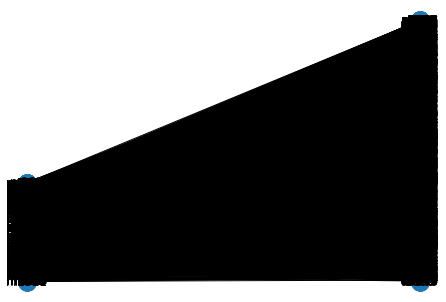

In [12]:
l, r = nx.bipartite.sets(A)
pos = {}

pos.update((node, (1, index)) for index, node in enumerate(l))
pos.update((node, (2, index)) for index, node in enumerate(r))
  
nx.draw(A, pos=pos, with_labels=True)
plt.show()

In [13]:
movies = []
actors = []
for i in A.nodes():
    if 'm' in i:
        movies.append(i)
    if 'a' in i:
        actors.append(i)
print('number of movies ', len(movies))
print('number of actors ', len(actors))

number of movies  1292
number of actors  3411


In [14]:
# Create the random walker
rw = UniformRandomMetaPathWalk(StellarGraph(A))

# specify the metapath schemas as a list of lists of node types.
metapaths = [
    ["movie", "actor", "movie"],
    ["actor", "movie", "actor"]
]

walks = rw.run(nodes=list(A.nodes()), # root nodes
               length=100,  # maximum length of a random walk
               n=1,        # number of random walks per root node 
               metapaths=metapaths
              )

print("Number of random walks: {}".format(len(walks)))

Number of random walks: 4703


In [15]:
from gensim.models import Word2Vec
model = Word2Vec(walks, vector_size=128, window=5)

In [16]:
model.wv.vectors.shape  # 128-dimensional vector for each node in the graph

(4703, 128)

In [17]:
# Retrieve node embeddings and corresponding subjects
node_ids = model.wv.index_to_key  # list of node IDs
node_embeddings = model.wv.vectors  # numpy.ndarray of size number of nodes times embeddings dimensionality
node_targets = [ A.nodes[node_id]['label'] for node_id in node_ids]

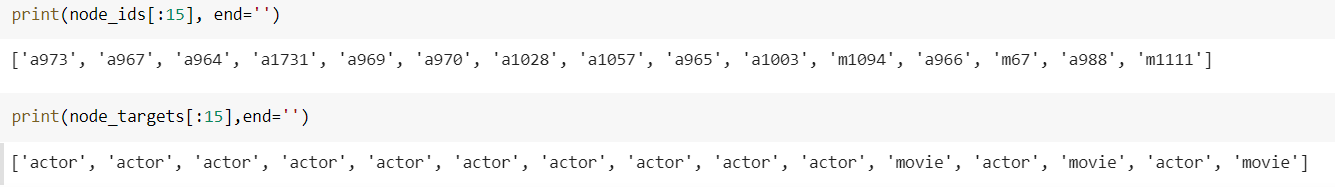

In [18]:
len(node_ids),len(node_embeddings),len(node_targets)

(4703, 4703, 4703)

In [19]:
def data_split(node_ids,node_targets,node_embeddings):
    '''In this function, we will split the node embeddings into actor_embeddings , movie_embeddings '''
    actor_nodes,movie_nodes=[],[]
    actor_embeddings,movie_embeddings=[],[]
    # split the node_embeddings into actor_embeddings,movie_embeddings based on node_ids
    # By using node_embedding and node_targets, we can extract actor_embedding and movie embedding
    # By using node_ids and node_targets, we can extract actor_nodes and movie nodes
    for i in range(len(node_ids)):
        node_type = node_ids[i][0]
        if node_type == 'a':
            actor_nodes.append(node_ids[i])
            actor_embeddings.append(node_embeddings[i])
        else:
            movie_nodes.append(node_ids[i])
            movie_embeddings.append(node_embeddings[i])
    
    return actor_nodes,movie_nodes,actor_embeddings,movie_embeddings
actor_nodes,movie_nodes,actor_embeddings,movie_embeddings = data_split(node_ids,node_targets,node_embeddings)

<font color='cyan'>Grader function - 1</font>

In [20]:
def grader_actors(data):
    assert(len(data)==3411)
    return True
grader_actors(actor_nodes)

True

<font color='cyan'>Grader function - 2</font>

In [21]:
def grader_movies(data):
    assert(len(data)==1292)
    return True
grader_movies(movie_nodes)

True

<font color='blue'>Calculating cost1</font>

Cost1 = $\frac{1}{N}\sum_{\text{each cluster i}}  \frac{\text{(number of nodes in the largest connected component in the graph with the actor nodes and its movie neighbours in cluster i)}}{\text{(total number of nodes in that cluster i)}}$ where N= number of clusters <br><br>
<br>

In [22]:
def cost1(graph,number_of_clusters):
    '''In this function, we will calculate cost1'''
    connected_com = [graph.subgraph(c) for c in nx.connected_components(graph)]
    total_node = graph.number_of_nodes()
    lagest_conn = max([ subg.number_of_nodes() for subg in connected_com ])
    cost1= (lagest_conn/total_node)*(1/number_of_clusters)
    return cost1

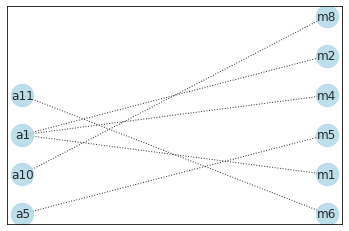

In [23]:
import networkx as nx
from networkx.algorithms import bipartite
graded_graph= nx.Graph()
graded_graph.add_nodes_from(['a1','a5','a10','a11'], bipartite=0) # Add the node attribute "bipartite"
graded_graph.add_nodes_from(['m1','m2','m4','m6','m5','m8'], bipartite=1)
graded_graph.add_edges_from([('a1','m1'),('a1','m2'),('a1','m4'),('a11','m6'),('a5','m5'),('a10','m8')])
l={'a1','a5','a10','a11'};r={'m1','m2','m4','m6','m5','m8'}
pos = {}
pos.update((node, (1, index)) for index, node in enumerate(l))
pos.update((node, (2, index)) for index, node in enumerate(r))
nx.draw_networkx(graded_graph, pos=pos, with_labels=True,node_color='lightblue',alpha=0.8,style='dotted',node_size=500)

<font color='cyan'>Grader function - 3</font>

In [24]:
graded_cost1=cost1(graded_graph,3)
def grader_cost1(data):
    assert(data==((1/3)*(4/10))) # 1/3 is number of clusters
    return True
grader_cost1(graded_cost1)

True

<font color='blue'>Calculating cost2</font>

Cost2 = $\frac{1}{N}\sum_{\text{each cluster i}}  \frac{\text{(sum of degress of actor nodes in the graph with the actor nodes and its movie neighbours in cluster i)}}{\text{(number of unique movie nodes in the graph with the actor nodes and its movie neighbours in cluster i)}}$ where N= number of clusters 

In [25]:
nodes = list(B.nodes())
B.degree('a1')

5

In [35]:
def cost2(graph,number_of_clusters):
    '''In this function, we will calculate cost1'''
    all_nodes = list(graph.nodes())
    sum_degree_actor = 0
    unique_movies = 0
    for node in all_nodes:
        if node[0] == 'a':
            sum_degree_actor += graph.degree(node)
        else:
            unique_movies+=1
    #print(sum_degree_actor)
    cost2= (sum_degree_actor/unique_movies)*(1/number_of_clusters)
    
    return cost2

<font color='cyan'>Grader function - 4</font>

In [27]:
graded_cost2=cost2(graded_graph,3)
def grader_cost2(data):
    assert(data==((1/3)*(6/6))) # 1/3 is number of clusters
    return True
grader_cost2(graded_cost2)

6


True

<font color='blue'>Grouping similar actors</font>

In [31]:
from tqdm import tqdm 

In [39]:
for number_of_clusters in tqdm([3, 5, 10, 30, 50, 100, 200, 500]):
    algo = KMeans(n_clusters=number_of_clusters)
    algo.fit(actor_embeddings)
    clusters = [ [] for i in range(number_of_clusters)]
    for i in range(len(actor_nodes)):
        clusters[algo.labels_[i]].append(actor_nodes[i])
    c1,c2 = 0,0
    full_G = []
    for c in clusters:
        G = nx.Graph()
        for node in c:
            sub_sub_graph = nx.ego_graph(A,node)
            G.add_nodes_from(sub_sub_graph.nodes)
            G.add_edges_from(sub_sub_graph.edges())
        full_G.append(G)
    c1,c2 = 0,0
    for subg in full_G:
        c1 += cost1(subg,number_of_clusters)
        c2 += cost2(subg,number_of_clusters)
    print(f"Cluster: {number_of_clusters} ---> Cost: {c1*c2}")

 12%|█▎        | 1/8 [00:05<00:41,  5.92s/it]

Cluster: 3 ---> Cost: 3.7013008112904657


 25%|██▌       | 2/8 [00:11<00:35,  6.00s/it]

Cluster: 5 ---> Cost: 2.869341745346898


 38%|███▊      | 3/8 [00:18<00:30,  6.10s/it]

Cluster: 10 ---> Cost: 2.4802443200370496


 50%|█████     | 4/8 [00:27<00:29,  7.35s/it]

Cluster: 30 ---> Cost: 1.7054738602776147


 62%|██████▎   | 5/8 [00:37<00:24,  8.31s/it]

Cluster: 50 ---> Cost: 1.5935579892280765


 75%|███████▌  | 6/8 [00:51<00:20, 10.23s/it]

Cluster: 100 ---> Cost: 1.6028063404795043


 88%|████████▊ | 7/8 [01:05<00:11, 11.57s/it]

Cluster: 200 ---> Cost: 1.7709212060998096


100%|██████████| 8/8 [01:25<00:00, 10.70s/it]

Cluster: 500 ---> Cost: 1.9411365201382562


<font color='blue'>Displaying similar actor clusters</font>

The Best clustering is with number of clusters as 2

Text(0.5, 1.0, 'TSNE 2D visualization of actor embedding')

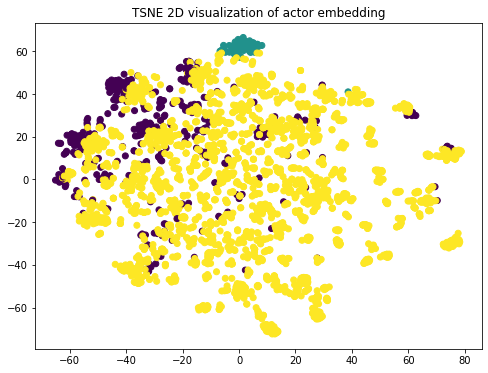

In [49]:
best_model  = KMeans(n_clusters=3)
best_model.fit(actor_embeddings)

from sklearn.manifold import TSNE
transform = TSNE #PCA

trans = transform(n_components=2)
node_embeddings_2d = trans.fit_transform(actor_embeddings)

import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6)) #https://stackoverflow.com/questions/28227340/kmeans-scatter-plot-plot-different-colors-per-cluster
plt.scatter(node_embeddings_2d[:,0], node_embeddings_2d[:,1], c=best_model.labels_.astype(float))
plt.title('TSNE 2D visualization of actor embedding')

<font color='blue'>Grouping similar movies</font>

In [50]:
def cost2m(graph,number_of_clusters):
    '''In this function, we will calculate cost1'''
    all_nodes = list(graph.nodes())
    sum_degree_movies = 0
    unique_actor = 0
    for node in all_nodes:
        if node[0] == 'm':
            sum_degree_movies += graph.degree(node)
        else:
            unique_actor+=1
    #print(sum_degree_actor)
    cost2= (sum_degree_movies/unique_actor)*(1/number_of_clusters)
    return cost2

for number_of_clusters in [3, 5, 10, 30, 50, 100, 200, 500]:
    algo = KMeans(n_clusters=number_of_clusters)
    algo.fit(movie_embeddings)
    clusters = [ [] for i in range(number_of_clusters)]
    for i in range(len(movie_nodes)):
        clusters[algo.labels_[i]].append(movie_nodes[i])
    c1,c2 = 0,0
    full_G = []
    for c in clusters:
        G = nx.Graph()
        for node in c:
            sub_sub_graph = nx.ego_graph(A,node)
            G.add_nodes_from(sub_sub_graph.nodes)
            G.add_edges_from(sub_sub_graph.edges())
        full_G.append(G)
    c1,c2 = 0,0
    for subg in full_G:
        c1 += cost1(subg,number_of_clusters)
        c2 += cost2m(subg,number_of_clusters)
    print(f"Cluster: {number_of_clusters} ---> Cost: {c1*c2}")

Cluster: 3 ---> Cost: 2.946527863633309
Cluster: 5 ---> Cost: 2.5984020403630916
Cluster: 10 ---> Cost: 2.0947352494276474
Cluster: 30 ---> Cost: 2.1857597801966926
Cluster: 50 ---> Cost: 1.8722857041721215
Cluster: 100 ---> Cost: 1.605877861588195
Cluster: 200 ---> Cost: 1.3698359583676485
Cluster: 500 ---> Cost: 1.211579805441419


<font color='blue'>Displaying similar movie clusters</font>

Text(0.5, 1.0, 'TSNE 2D visualization of Movie embedding')

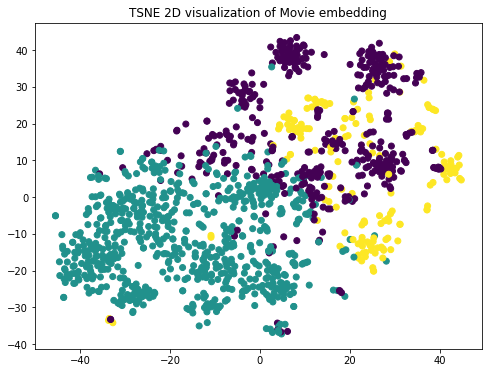

In [51]:
best_model_movies  = KMeans(n_clusters=3)
best_model_movies.fit(movie_embeddings)

trans = transform(n_components=2)
movie_embeddings_2d = trans.fit_transform(movie_embeddings)

plt.figure(figsize=(8, 6))
plt.scatter(movie_embeddings_2d[:,0], movie_embeddings_2d[:,1], c=best_model_movies.labels_.astype(float))
plt.title('TSNE 2D visualization of Movie embedding')